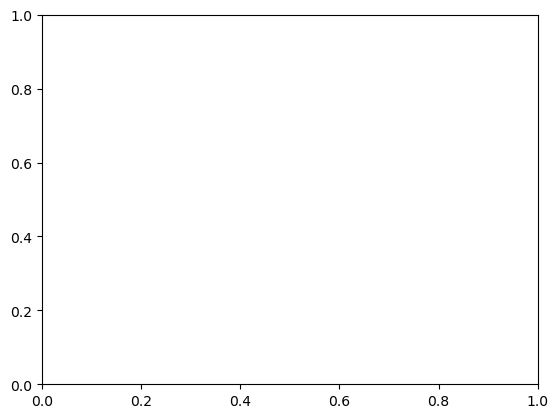

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
import scipy.integrate as integrate
import endf
import pandas as pd
import os
fig,ax=plt.subplots()

In [40]:
element_symbols=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh',	'Pd','Ag','Cd','In','Sn','Sb','Te',	'I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No']

# Set up units (working in CGS system)
barn=1.e-24 #cm^2

# MT IDs of reactions under consideration
reaction_ids=[16,17,18,102,103]
reaction_strs=["(n,2n)","(n,3n)","(n,fission)","(n,$\gamma$)","(n,p)"]

burnups=["BoL","BoC","EoC","EoL"]




<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_28056/1894322638.py:8: SyntaxWarning: invalid escape sequence '\g'
  reaction_strs=["(n,2n)","(n,3n)","(n,fission)","(n,$\gamma$)","(n,p)"]


In [41]:
# csv file with the edges of the energy groups
neutronspec_edges = 1e6*genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR multizone/neutronspec_edges_scale252.csv', delimiter=',')


n_energy_bins=len(neutronspec_edges)-1


neutronspec_flux_inner = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR multizone/neutronspec_flux_inner.csv', delimiter=',')

neutronspec_flux_inner=neutronspec_flux_inner[1:,:]

neutronspec_flux_outer = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR multizone/neutronspec_flux_outer.csv', delimiter=',')

neutronspec_flux_outer=neutronspec_flux_outer[1:,:]

neutronspec_flux_middle = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR multizone/neutronspec_flux_middle.csv', delimiter=',')

neutronspec_flux_middle=neutronspec_flux_middle[1:,:]






In [42]:
# Get JEFF 3.3 reaction cross-sections

# Select element, isotope and reaction (by MT ID)
lib_dir='/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/nuclear data/JEFF/'

jeff_reactions = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/JEFF_reactions.csv', delimiter=',')

n_reactions=len(jeff_reactions[:,0])

#test_A=115
#test_reaction_id=102

# Get Z from element symbol

for i in range(n_reactions):
    parent_ZAI=jeff_reactions[i,0]

    test_reaction_id=jeff_reactions[i,1]

    meta_flag=np.mod(parent_ZAI,10)
    #print(meta_flag)
    #print("%i, %i" % (parent_ZAI,test_reaction_id))
    parent_ZA=parent_ZAI-meta_flag

    parent_Z=int(parent_ZA/10000)
    parent_A=int(((parent_ZA)-(10000*parent_Z))/10)

    if(meta_flag==1): meta_str="m"
    else: meta_str="g"

    element=element_symbols[parent_Z-1]
    filename="%i-%s-%i%s-900.ace" % (parent_Z,element,parent_A,meta_str)

    infile_str=lib_dir+filename

    table = endf.ace.get_table(infile_str)

    test_reaction = (table.interpret().reactions[test_reaction_id].xs)['900K']



    d1 = {'Energy': test_reaction.x, 'Sigma': test_reaction.y}
    test_df=pd.DataFrame(data=d1)

    # group cross-section data according to the neutron spec group structure
    grouped_xs_df=test_df.groupby(pd.cut(test_df["Energy"],neutronspec_edges),observed=False).mean()

    grouped_xs_df=grouped_xs_df.Sigma.reset_index()
    grouped_xs=grouped_xs_df["Sigma"].copy()


    # if all NaN (i.e. no overlap between xs data and neutronspec data) skip reaction
    if(sum(np.isnan(grouped_xs))==len(grouped_xs)): continue

    # if last value is NaN - replace with zeros, count back and replace with zero until a non-NaN value is found
    if(np.isnan(grouped_xs[len(grouped_xs)-1])==1):
        stop_flag=0
        index=len(grouped_xs)-1
        print(index)
        while(stop_flag==0):
            grouped_xs[index]=0
            if(np.isnan(grouped_xs[index-1])==1):
                index-=1
            else:
                stop_flag=1

    # if first value is NaN - replace with zeros, count forward and replace with zero until a non-NaN value is found
    if(np.isnan(grouped_xs[0])==1):
        stop_flag=0
        index=0
        while(stop_flag==0):
            grouped_xs[index]=0
            if(np.isnan(grouped_xs[index+1])==1):
                index+=1
            else:
                stop_flag=1


    # check if any NaN values remain
    any_nan=0
    if(np.sum(np.isnan(grouped_xs))>0): any_nan=1

    while(any_nan==1):
        # count through NaN values, replace each with interpolation from the two closest values
        for i in range(1,len(grouped_xs)-1):
            if np.isnan(grouped_xs[i]):
                lb=1
                while((np.isnan(grouped_xs[i-lb])==1) & ((i-lb)>1)):
                    lb+=1
                ub=1
                while((np.isnan(grouped_xs[i+ub])==1) & ((i+ub)<len(grouped_xs)-1)):
                    ub+=1
                grouped_xs[i]=0.5*(grouped_xs[i-lb]+grouped_xs[i+ub])
        if(np.sum(np.isnan(grouped_xs))==0): any_nan=0   


    for b in range(4):
        neutronspec_flux=neutronspec_flux_inner[:,b]


        prod_sum=0
        flux_sum=0
        for i in range(len(grouped_xs)):
            if(np.isnan(grouped_xs[i])): grouped_xs[i]=0
            prod_sum+=grouped_xs[i]*neutronspec_flux[i]
            flux_sum+=neutronspec_flux[i]


        if test_reaction_id==16:
            daughter_Z=parent_Z
            daughter_A=parent_A-1
        if test_reaction_id==17:
            daughter_Z=parent_Z
            daughter_A=parent_A-2
        if test_reaction_id==102:
            daughter_Z=parent_Z
            daughter_A=parent_A+1
        if test_reaction_id==103:
            daughter_Z=parent_Z-1
            daughter_A=parent_A
        if test_reaction_id==18:
            daughter_Z=0
            daughter_A=0
        daughter_ZAI=(daughter_Z*10000)+(daughter_A*10)
        print("%s,%i,%i,%i,%.5e" % (burnups[b],parent_ZAI,test_reaction_id,daughter_ZAI,(prod_sum/flux_sum)))




BoL,10010,102,10020,2.00355e-04
BoC,10010,102,10020,2.02039e-04
EoC,10010,102,10020,2.03211e-04
EoL,10010,102,10020,2.04623e-04
BoL,10020,16,10010,5.63305e-04
BoC,10020,16,10010,5.51617e-04
EoC,10020,16,10010,5.45226e-04
EoL,10020,16,10010,5.35946e-04
BoL,10020,102,10030,3.12979e-06
BoC,10020,102,10030,3.11012e-06
EoC,10020,102,10030,3.09844e-06
EoL,10020,102,10030,3.08287e-06
BoL,10030,16,10020,1.08461e-05
BoC,10030,16,10020,1.05868e-05
EoC,10030,16,10020,1.04898e-05
EoL,10030,16,10020,1.02886e-05
BoL,20030,102,20040,3.46084e-05
BoC,20030,102,20040,3.43693e-05
EoC,20030,102,20040,3.42246e-05
EoL,20030,102,20040,3.40342e-05
BoL,20030,103,10030,3.24511e+00
BoC,20030,103,10030,3.26894e+00
EoC,20030,103,10030,3.28563e+00
EoL,20030,103,10030,3.30578e+00
BoL,30060,102,30070,2.96407e-05
BoC,30060,102,30070,2.98235e-05
EoC,30060,102,30070,2.99510e-05
EoL,30060,102,30070,3.01049e-05
BoL,30060,103,20060,4.63953e-04
BoC,30060,103,20060,4.54582e-04
EoC,30060,103,20060,4.49227e-04
EoL,30060,103,20

In [43]:
# Get remaining ENDF reaction cross-sections

# Select element, isotope and reaction (by MT ID)
lib_dir='/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/nuclear data/ENDF/Lib80x/Lib80x/'

missing_reactions = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/reactions_in_endf_not_jeff.csv', delimiter=',')

n_reactions=len(missing_reactions[:,0])

#test_A=115
#test_reaction_id=102

# Get Z from element symbol

for i in range(n_reactions):
    parent_ZAI=missing_reactions[i,0]

    test_reaction_id=missing_reactions[i,1]

    meta_flag=np.mod(parent_ZAI,10)
    #print("%i, %s, %i" % (parent_ZAI,ZAI_str,meta_flag))
    file_ZA=int(parent_ZAI/10)
    parent_Z=int(parent_ZAI/10000)
    parent_A=int((parent_ZAI-(10000*parent_Z))/10)

    if(meta_flag==1): meta_str="m1_"
    else: meta_str=""

    element=element_symbols[parent_Z-1]
    #print(meta_str)
    #print(file_ZA)

    filename="%s/%s%i.802nc" % (element,meta_str,file_ZA)

    infile_str=lib_dir+filename

    table = endf.ace.get_table(infile_str)

    test_reaction = (table.interpret().reactions[test_reaction_id].xs)['900K']



    d1 = {'Energy': test_reaction.x, 'Sigma': test_reaction.y}
    test_df=pd.DataFrame(data=d1)

    # group cross-section data according to the neutron spec group structure
    grouped_xs_df=test_df.groupby(pd.cut(test_df["Energy"],neutronspec_edges),observed=False).mean()

    grouped_xs_df=grouped_xs_df.Sigma.reset_index()
    grouped_xs=grouped_xs_df["Sigma"].copy()

    # if all NaN (i.e. no overlap between xs data and neutronspec data) skip reaction
    if(sum(np.isnan(grouped_xs))==len(grouped_xs)): continue

    # if last value is NaN - replace with zeros, count back and replace with zero until a non-NaN value is found
    if(np.isnan(grouped_xs[len(grouped_xs)-1])==1):
        stop_flag=0
        index=len(grouped_xs)-1
        print(index)
        while(stop_flag==0):
            grouped_xs[index]=0
            if(np.isnan(grouped_xs[index-1])==1):
                index-=1
            else:
                stop_flag=1

    # if first value is NaN - replace with zeros, count forward and replace with zero until a non-NaN value is found
    if(np.isnan(grouped_xs[0])==1):
        stop_flag=0
        index=0
        while(stop_flag==0):
            grouped_xs[index]=0
            if(np.isnan(grouped_xs[index+1])==1):
                index+=1
            else:
                stop_flag=1


    # check if any NaN values remain
    any_nan=0
    if(np.sum(np.isnan(grouped_xs))>0): any_nan=1

    while(any_nan==1):
        # count through NaN values, replace each with interpolation from the two closest values
        for i in range(1,len(grouped_xs)-1):
            if np.isnan(grouped_xs[i]):
                lb=1
                while((np.isnan(grouped_xs[i-lb])==1) & ((i-lb)>1)):
                    lb+=1
                ub=1
                while((np.isnan(grouped_xs[i+ub])==1) & ((i+ub)<len(grouped_xs)-1)):
                    ub+=1
                grouped_xs[i]=0.5*(grouped_xs[i-lb]+grouped_xs[i+ub])
        if(np.sum(np.isnan(grouped_xs))==0): any_nan=0   


    for b in range(4):
        neutronspec_flux=neutronspec_flux_inner[:,b]


        prod_sum=0
        flux_sum=0
        for i in range(len(grouped_xs)):
            if(np.isnan(grouped_xs[i])): grouped_xs[i]=0
            prod_sum+=grouped_xs[i]*neutronspec_flux[i]
            flux_sum+=neutronspec_flux[i]


        if test_reaction_id==16:
            daughter_Z=parent_Z
            daughter_A=parent_A-1
        if test_reaction_id==17:
            daughter_Z=parent_Z
            daughter_A=parent_A-2
        if test_reaction_id==102:
            daughter_Z=parent_Z
            daughter_A=parent_A+1
        if test_reaction_id==103:
            daughter_Z=parent_Z-1
            daughter_A=parent_A
        if test_reaction_id==18:
            daughter_Z=0
            daughter_A=0
        daughter_ZAI=(daughter_Z*10000)+(daughter_A*10)
        print("%s,%i,%i,%i,%.5e" % (burnups[b],parent_ZAI,test_reaction_id,daughter_ZAI,(prod_sum/flux_sum)))



BoL,40070,103,30070,1.71846e+01
BoC,40070,103,30070,1.73332e+01
EoC,40070,103,30070,1.74395e+01
EoL,40070,103,30070,1.75674e+01
BoL,40090,16,40080,1.06610e-02
BoC,40090,16,40080,1.04477e-02
EoC,40090,16,40080,1.03253e-02
EoL,40090,16,40080,1.01551e-02
BoL,60120,102,60130,2.28975e-05
BoC,60120,102,60130,2.27878e-05
EoC,60120,102,60130,2.27227e-05
EoL,60120,102,60130,2.26362e-05
BoL,60120,103,50120,2.96216e-08
BoC,60120,103,50120,2.82603e-08
EoC,60120,103,50120,2.80292e-08
EoL,60120,103,50120,2.70004e-08
BoL,240500,16,240490,2.99136e-07
BoC,240500,16,240490,2.88087e-07
EoC,240500,16,240490,2.84357e-07
EoL,240500,16,240490,2.78603e-07
BoL,240500,103,230500,4.84761e-03
BoC,240500,103,230500,4.74971e-03
EoC,240500,103,230500,4.69427e-03
EoL,240500,103,230500,4.61616e-03
BoL,240530,16,240520,1.03779e-04
BoC,240530,16,240520,1.01220e-04
EoC,240530,16,240520,1.00293e-04
EoL,240530,16,240520,9.84194e-05
BoL,240530,103,230530,3.49419e-05
BoC,240530,103,230530,3.41972e-05
EoC,240530,103,230530,3.